In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import re
import pickle
import os
import shutil
import glob
import time
import matplotlib.pyplot as plt

from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss, MSELoss
from collections import Counter
from tqdm import tqdm

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('research_gaps_dataset.csv')

print(f"Dataset loaded: {df.shape}")
print("Columns:", df.columns.tolist())

# Checking gap corpus
print("\nSample gap corpus:")
print(df['gap_corpus'].head(5).values)

Dataset loaded: (80318, 33)
Columns: ['paperID', 'venue', 'year', 'openAccessPdf', 'url', 'authors', 'referenceCount', 'title', 'abstract', 'conclusion', 'Chatgpt Response', 'Key Takeaways', 'Importance', 'Model/Method Proposed', 'Performance', 'Effectiveness', 'Future Works', 'Sentiment', 'Sentiment Score', 'combined', 'combined_keywords', 'response_keywords', 'future_work_keywords', 'capped_keywords', 'field', 'future_work_cleaned', 'abstract_cleaned', 'method_proposed_cleaned', 'conclusion_cleaned', 'gap_corpus', 'gap_sentences', 'contextual_gaps', 'domain_gaps']

Sample gap corpus:
["[ABSTRACT] face anti-spoofing approach based on domain generalization (dg) has drawn growing attention due to its robustness for unseen scenarios. existing dg methods assume that the domain label is known. however, in real-world applications, the collected dataset always contains mixture domains, where the domain label is unknown. in this case, most of existing methods may not work. further, even if we

In [8]:
gap_stats = {
    'gap_corpus': df['gap_corpus'].notna().sum(),
    'gap_sentences': df['gap_sentences'].str.len().sum() if 'gap_sentences' in df.columns else 0,
    'future_work_cleaned': df['future_work_cleaned'].notna().sum(),
    'contextual_gaps': df['contextual_gaps'].str.len().sum() if 'contextual_gaps' in df.columns else 0
}

print("gap extraction stats")
for col, count in gap_stats.items():
    print(f"{col}: {count} entries")

print("sample training data")
sample_papers = df[df['gap_corpus'].str.len() > 100].head(3)

for i, (idx, row) in enumerate(sample_papers.iterrows()):
    print(f"\nsample {i+1}")
    print(f"field: {row['field']}")
    print(f"title: {row['title'][:80]}")
    print(f"gap corpus length: {len(row['gap_corpus'])} chars")
    print(f"future work: {row['future_work_cleaned'][:100]}")

gap extraction stats
gap_corpus: 80318 entries
gap_sentences: 40105051 entries
future_work_cleaned: 80318 entries
contextual_gaps: 7455434 entries
sample training data

sample 1
field: Artificial Intelligence
title: Generalizable Representation Learning for Mixture Domain Face Anti-Spoofing
gap corpus length: 3246 chars
future work: ['further enhance interpretability and visualization', 'explore applications to other domains beyond

sample 2
field: Artificial Intelligence
title: Coordinating Human and Agent Behavior in Collective-Risk Scenarios
gap corpus length: 1532 chars
future work: ['explore further applications of anticipatory behavior in complex social scenarios.', 'investigate 

sample 3
field: Artificial Intelligence
title: Adverse Drug Reaction Prediction with Symbolic Latent Dirichlet Allocation
gap corpus length: 2823 chars
future work: ['improvement of the medical ontology system with real-world evidence.', 'addressing issues related 


In [9]:
def create_transformer_training_data(df):
    # Input: Paper sections
    # Output: Research gaps

    training_examples = []

    for idx, row in df.iterrows():
        if pd.isna(row['gap_corpus']) or len(row['gap_corpus']) < 50:
            continue

        # combining paper sections
        input_sections = []

        if pd.notna(row['title']):
            input_sections.append(f"Title: {row['title']}")
        if pd.notna(row['abstract_cleaned']):
            input_sections.append(f"Abstract: {row['abstract_cleaned'][:500]}")
        if pd.notna(row['method_proposed_cleaned']):
            input_sections.append(f"Method: {row['method_proposed_cleaned'][:400]}")
        if pd.notna(row['conclusion_cleaned']):
            input_sections.append(f"Conclusion: {row['conclusion_cleaned'][:300]}")

        paper_input = "\n".join(input_sections)

        # extracting research gaps from processed columns
        research_gaps = []

        # Future work
        if pd.notna(row['future_work_cleaned']) and len(row['future_work_cleaned']) > 20:
            research_gaps.append(f"Future Research: {row['future_work_cleaned'][:200]}")

        # Gap sentences
        if 'gap_sentences' in df.columns and pd.notna(row['gap_sentences']):
            if isinstance(row['gap_sentences'], list) and len(row['gap_sentences']) > 0:
                for gap in row['gap_sentences'][:3]:
                    if len(gap) > 20:
                        research_gaps.append(f"Limitation: {gap[:150]}")

        if len(research_gaps) > 0 and len(paper_input) > 100:
            gap_output = "\n".join(research_gaps)

            training_examples.append({
                'input_text': paper_input,
                'target_text': gap_output,
                'field': row['field'],
                'paper_id': row['paperID']
            })

    return training_examples

In [10]:
# Creating training dataset
print("Creating training dataset")
training_examples = create_transformer_training_data(df)
print(f"Created {len(training_examples)} training examples")

# Showing distribution by field
field_counts = {}
for example in training_examples:
    field = example['field']
    field_counts[field] = field_counts.get(field, 0) + 1

print("\ntraining data ny field:")
for field, count in sorted(field_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{field}: {count} examples")

Creating training dataset
Created 80080 training examples

training data ny field:
Computational Theory: 16095 examples
Computer Vision: 14779 examples
Natural Language Processing: 13868 examples
Artificial Intelligence: 11890 examples
Human Computer Interaction: 6882 examples
Computing in Biomedical Fields: 4575 examples
Computer Networks & Communications: 3852 examples
Graphics and Computer-Aided Design: 3046 examples
Software Engineering: 2333 examples
Computer Hardware & Architecture: 1214 examples


In [29]:
# Custom Transformer Model
class CustomResearchGapTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, max_seq_length=1024, dropout=0.1):
        super(CustomResearchGapTransformer, self).__init__()

        self.d_model = d_model
        self.max_seq_length = max_seq_length

        # Embedding layers
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.output_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Encoder and Decoder separately
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_decoder_layers
        )

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Research gap specific layers
        self.gap_classifier = nn.Linear(d_model, 7)
        self.gap_importance = nn.Linear(d_model, 1)

    def create_padding_mask(self, x, pad_token_id=0):
        return (x == pad_token_id)

    def create_causal_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        return mask.bool()

    def forward(self, src, tgt, src_pad_mask=None, tgt_pad_mask=None):
        batch_size, src_seq_len = src.shape
        tgt_seq_len = tgt.shape[1]

        # Creating padding masks
        if src_pad_mask is None:
            src_pad_mask = self.create_padding_mask(src)
        if tgt_pad_mask is None:
            tgt_pad_mask = self.create_padding_mask(tgt)

        # Creating causal masks
        tgt_causal_mask = self.create_causal_mask(tgt_seq_len).to(src.device)

        # Embeddings with positional encoding
        src_emb = self.input_embedding(src) * math.sqrt(self.d_model)
        tgt_emb = self.output_embedding(tgt) * math.sqrt(self.d_model)

        src_emb = self.positional_encoding(src_emb)
        tgt_emb = self.positional_encoding(tgt_emb)

        # Encoder forward pass
        encoder_output = self.transformer_encoder(
            src_emb,
            src_key_padding_mask=src_pad_mask
        )

        # Decoder forward pass
        decoder_output = self.transformer_decoder(
            tgt_emb,
            encoder_output,
            tgt_mask=tgt_causal_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=src_pad_mask
        )

        # Output projections
        gap_text_logits = self.output_projection(decoder_output)

        # Using encoder output for global context
        encoder_mask = ~src_pad_mask.unsqueeze(-1)  # Inverting mask for multiplication
        masked_encoder_output = encoder_output * encoder_mask.float()
        global_features = masked_encoder_output.sum(dim=1) / encoder_mask.sum(dim=1).float()

        gap_types = self.gap_classifier(global_features)
        gap_scores = self.gap_importance(global_features)

        return {
            'gap_text': gap_text_logits,
            'gap_types': gap_types,
            'gap_scores': gap_scores.squeeze(-1)
        }

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, droput=0.1):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_parameter('pe', nn.Parameter(pe.unsqueeze(0), requires_grad=False))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

print("Custom Transformer Model Defined")

Custom Transformer Model Defined


In [30]:
# Building vocabulary from dataset
class ResearchGapVocabulary:
    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.vocab_size = 4

    def build_vocabulary(self, texts):
        print("Building vocabulary from research papers")

        word_counts = Counter()
        for text in texts:
            # Tokenization
            words = re.findall(r'\b\w+\b', text.lower())
            word_counts.update(words)

        for word, count in word_counts.items():
            if count >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = self.vocab_size
                self.idx2word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary built: {self.vocab_size} words")
        return word_counts

    def text_to_indices(self, text, max_length=512):
        words = re.findall(r'\b\w+\b', text.lower())
        indices = [self.word2idx.get(word, 1) for word in words]  # 1=<UNK>

        # Adding SOS token at beginning, EOS at end
        indices = [2] + indices + [3]  # 2=<SOS>, 3=<EOS>

        # Padding to max_length
        if len(indices) > max_length:
            indices = indices[:max_length-1] + [3]  # Keeping EOS token
        else:
            indices += [0] * (max_length - len(indices))  # 0=<PAD>

        return indices

    def indices_to_text(self, indices):
        # Converting indices back to text
        words = []
        for idx in indices:
            if idx == 3:  # EOS token
                break
            if idx not in [0, 1, 2]:  # Skipping PAD, UNK, SOS
                words.append(self.idx2word.get(idx, '<UNK>'))
        return ' '.join(words)

In [31]:
# Building vocabulary from training data
all_texts = []
for example in training_examples:
    all_texts.append(example['input_text'])
    all_texts.append(example['target_text'])

vocabulary = ResearchGapVocabulary(min_freq=3)
word_counts = vocabulary.build_vocabulary(all_texts)

print(f"Vocabulary Statistics:")
print(f"\nTotal unique words: {len(word_counts)}")
print(f"\nVocabulary size: {vocabulary.vocab_size}")
print(f"\nMost common words: {word_counts.most_common(10)}")

with open('research_gap_vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)

Building vocabulary from research papers
Vocabulary built: 53657 words
Vocabulary Statistics:

Total unique words: 103209

Vocabulary size: 53657

Most common words: [('the', 468884), ('of', 384901), ('to', 279725), ('and', 275810), ('in', 245934), ('a', 233653), ('for', 232795), ('we', 131127), ('method', 112396), ('on', 104444)]


In [32]:
# Custom dataset class
class ResearchGapDataset(Dataset):
    def __init__(self, training_examples, vocabulary, max_input_length=512, max_output_length=256):
        self.examples = training_examples
        self.vocabulary = vocabulary
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Converting texts to indices
        input_indices = self.vocabulary.text_to_indices(
            example['input_text'], self.max_input_length
        )
        target_indices = self.vocabulary.text_to_indices(
            example['target_text'], self.max_output_length
        )

        # Creating decoder input
        decoder_input = target_indices[:-1]  # Removing last token
        decoder_target = target_indices[1:]   # Removing first token

        # Padding decoder sequences to same length
        if len(decoder_input) < self.max_output_length - 1:
            pad_length = self.max_output_length - 1 - len(decoder_input)
            decoder_input.extend([0] * pad_length)
            decoder_target.extend([0] * pad_length)

        return {
            'input_ids': torch.tensor(input_indices, dtype=torch.long),
            'decoder_input': torch.tensor(decoder_input, dtype=torch.long),
            'decoder_target': torch.tensor(decoder_target, dtype=torch.long),
            'field': example['field'],
            'paper_id': example['paper_id']
        }

In [15]:
# Creating dataset splits
train_size = int(0.8 * len(training_examples))
val_size = int(0.1 * len(training_examples))
test_size = len(training_examples) - train_size - val_size

train_examples = training_examples[:train_size]
val_examples = training_examples[train_size:train_size + val_size]
test_examples = training_examples[train_size + val_size:]

print(f"\nDataset Splits:")
print(f"\nTraining: {len(train_examples)} examples")
print(f"\nValidation: {len(val_examples)} examples")
print(f"\nTest: {len(test_examples)} examples")

# Creating datasets
train_dataset = ResearchGapDataset(train_examples, vocabulary)
val_dataset = ResearchGapDataset(val_examples, vocabulary)
test_dataset = ResearchGapDataset(test_examples, vocabulary)

BATCH_SIZE = 8
print(f"Data loaders created with batch size: {BATCH_SIZE}")
def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [item['input_ids'] for item in batch], batch_first=True, padding_value=vocabulary.word2idx['<PAD>']
    )
    decoder_inputs = torch.nn.utils.rnn.pad_sequence(
        [item['decoder_input'] for item in batch], batch_first=True, padding_value=vocabulary.word2idx['<PAD>']
    )
    decoder_targets = torch.nn.utils.rnn.pad_sequence(
        [item['decoder_target'] for item in batch], batch_first=True, padding_value=vocabulary.word2idx['<PAD>']
    )

    fields = [item['field'] for item in batch]
    paper_ids = [item['paper_id'] for item in batch]

    return {
        'input_ids': input_ids,
        'decoder_input': decoder_inputs,
        'decoder_target': decoder_targets,
        'field': fields,
        'paper_id': paper_ids
    }

# Creating data loaders with the collate_fn
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"\nData loaders created with batch size: {BATCH_SIZE} and dynamic padding.")



Dataset Splits:

Training: 64064 examples

Validation: 8008 examples

Test: 8008 examples
Data loaders created with batch size: 8

Data loaders created with batch size: 8 and dynamic padding.


In [33]:
# Model hyperparameters
MODEL_CONFIG = {
    'vocab_size': vocabulary.vocab_size,
    'd_model': 256,
    'nhead': 8,
    'num_encoder_layers': 4,
    'num_decoder_layers': 4,
    'dim_feedforward': 1024,
    'dropout': 0.3
}

print(f"Model Configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"   {key}: {value}")

# Initializing fixed model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if 'model' in locals():
    del model
torch.cuda.empty_cache()

model = CustomResearchGapTransformer(**MODEL_CONFIG)
model = model.to(device)

print("\nNew model initialized and pre-trained weights loaded successfully.")


Model Configuration:
   vocab_size: 53657
   d_model: 256
   nhead: 8
   num_encoder_layers: 4
   num_decoder_layers: 4
   dim_feedforward: 1024
   dropout: 0.3
Using device: cuda

New model initialized and pre-trained weights loaded successfully.


In [34]:
# Counting parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nFixed Model Statistics:")
print(f"\nTotal parameters: {total_params:,}")
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"\nModel size: ~{total_params * 4 / (1024**2):.1f} MB")

# Testing model with sample batch
sample_batch = next(iter(train_loader))
print(f"\nTesting fixed model with sample batch...")
print(f"\nInput shape: {sample_batch['input_ids'].shape}")
print(f"\nDecoder input shape: {sample_batch['decoder_input'].shape}")

# Moving to device and testing forward pass
sample_input = sample_batch['input_ids'].to(device)
sample_decoder = sample_batch['decoder_input'].to(device)

with torch.no_grad():
    try:
        output = model(sample_input, sample_decoder)
        print(f"Fixed model forward pass successful!")
        print(f"\nGap text output shape: {output['gap_text'].shape}")
        print(f"\nGap types output shape: {output['gap_types'].shape}")
        print(f"\nGap scores output shape: {output['gap_scores'].shape}")

        # Testing actual values
        print(f"\nSample Output Statistics:")
        print(f"\nGap text logits range: [{output['gap_text'].min():.3f}, {output['gap_text'].max():.3f}]")
        print(f"\nGap types range: [{output['gap_types'].min():.3f}, {output['gap_types'].max():.3f}]")
        print(f"\nGap scores range: [{output['gap_scores'].min():.3f}, {output['gap_scores'].max():.3f}]")

    except Exception as e:
        print(f"Model forward pass still failed: {e}")
        import traceback
        traceback.print_exc()


Fixed Model Statistics:

Total parameters: 48,899,233

Trainable parameters: 48,637,089

Model size: ~186.5 MB

Testing fixed model with sample batch...

Input shape: torch.Size([8, 512])

Decoder input shape: torch.Size([8, 255])
Fixed model forward pass successful!

Gap text output shape: torch.Size([8, 255, 53657])

Gap types output shape: torch.Size([8, 7])

Gap scores output shape: torch.Size([8])

Sample Output Statistics:

Gap text logits range: [-3.200, 3.061]

Gap types range: [-0.409, 0.411]

Gap scores range: [-0.112, 0.359]


In [35]:
# Defining Training Hyperparameters
TRAINING_CONFIG = {
    'num_epochs': 15,
    'learning_rate': 5e-5,
    'batch_size': 16,
    'weight_decay': 0.01, # L2 regularization
    'gradient_clipping': 0.5,
    'early_stopping_patience': 3,
    'reduce_lr_patience': 2,
    'reduce_lr_factor': 0.5
}

print("Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

# Defining the Combined Loss Function Dictionary
criterion = {
    'gap_text': CrossEntropyLoss(ignore_index=vocabulary.word2idx['<PAD>']),
    'gap_type': CrossEntropyLoss(),
    'gap_score': MSELoss()
}

# Creating the Optimizer and Scheduler for the training run
optimizer = optim.AdamW(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=TRAINING_CONFIG['reduce_lr_patience'],
    factor=TRAINING_CONFIG['reduce_lr_factor']
    )

print("\nNew training configuration, loss function, optimizer, and scheduler are ready.")

Training Configuration:
  num_epochs: 15
  learning_rate: 5e-05
  batch_size: 16
  weight_decay: 0.01
  gradient_clipping: 0.5
  early_stopping_patience: 3
  reduce_lr_patience: 2
  reduce_lr_factor: 0.5

New training configuration, loss function, optimizer, and scheduler are ready.


In [43]:
class ResearchGapTrainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        # training history
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        num_batches = len(train_loader)

        progress_bar = tqdm(train_loader, desc="training")

        for batch_idx, batch in enumerate(progress_bar):
            # moving batch to device
            input_ids = batch['input_ids'].to(self.device)
            decoder_input = batch['decoder_input'].to(self.device)
            decoder_target = batch['decoder_target'].to(self.device)

            # forward pass
            self.optimizer.zero_grad()
            predictions = self.model(input_ids, decoder_input)

            # loss calculation
            loss_text = self.criterion['gap_text'](predictions['gap_text'].reshape(-1, predictions['gap_text'].size(-1)), decoder_target.reshape(-1))
            loss = loss_text

            # backward pass
            loss.backward()

            # gradient limiting
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            # weight update
            self.optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{total_loss / (batch_idx + 1):.4f}'})

        return {'total_loss': total_loss / len(train_loader)}

    def validate(self, val_loader):
        # validating the model
        self.model.eval()
        total_loss = 0
        total_text_loss = 0
        num_batches = len(val_loader)

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="validation"):
                input_ids = batch['input_ids'].to(self.device)
                decoder_input = batch['decoder_input'].to(self.device)
                decoder_target = batch['decoder_target'].to(self.device)

                predictions = self.model(input_ids, decoder_input)
                loss = self.criterion['gap_text'](predictions['gap_text'].reshape(-1, predictions['gap_text'].size(-1)), decoder_target.reshape(-1))
                total_loss += loss.item()

        return {'total_loss': total_loss / len(val_loader)}


    def train(self, train_loader, val_loader, num_epochs):
        # completing training loop
        print(f"starting training for {num_epochs} epochs...")

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(num_epochs):
            print(f"\nepoch {epoch + 1}/{num_epochs}")

            # training
            start_time = time.time()
            train_metrics = self.train_epoch(train_loader)
            train_time = time.time() - start_time

            # validation
            start_time = time.time()
            val_metrics = self.validate(val_loader)
            val_time = time.time() - start_time

            # updating learning rate
            self.scheduler.step(val_metrics['total_loss'])
            current_lr = self.optimizer.param_groups[0]['lr']

            # stori history
            self.train_losses.append(train_metrics['total_loss'])
            self.val_losses.append(val_metrics['total_loss'])
            self.learning_rates.append(current_lr)

            # epoch summary
            print(f"\nepoch {epoch + 1} results:")
            print(f"\ntrain loss: {train_metrics['total_loss']:.4f} ({train_time:.1f}s)")
            print(f"\nval loss: {val_metrics['total_loss']:.4f} ({val_time:.1f}s)")
            print(f"\nlearning rate: {current_lr:.2e}")
            print(f"\ntext loss: {train_metrics['text_loss']:.4f}")

            # saved best model
            if val_metrics['total_loss'] < best_val_loss:
                best_val_loss = val_metrics['total_loss']
                self.save_model('best_research_gap_model.pt', epoch, val_metrics['total_loss'])
                patience_counter = 0
                print(f"\nnew best model saved!")
            else:
                patience_counter += 1

            # early stopping
            if patience_counter >= 5:
                print(f"\nearly stopping triggered (patience: 5)")
                break

            # saved checkpoint every few epochs
            if (epoch + 1) % 3 == 0:
                self.save_model(f'checkpoint_epoch_{epoch+1}.pt', epoch, val_metrics['total_loss'])

        print(f"\ntraining completed!")
        print(f"\nbest validation loss: {best_val_loss:.4f}")

    def save_model(self, filename, epoch, val_loss):
        # saved model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'vocab_size': self.model.output_projection.in_features,
            'model_config': MODEL_CONFIG
        }, filename)

    def plot_training_history(self):
      # plotting training curves
      fig, ax = plt.subplots(1, 1, figsize=(8, 5))

      ax.plot(self.train_losses, label='training loss', color='blue')
      ax.plot(self.val_losses, label='validation loss', color='red')
      ax.set_xlabel('epoch')
      ax.set_ylabel('loss')
      ax.set_title('training and validation loss')
      ax.set_ylim(2.75, 4.75)
      ax.legend()
      ax.grid(True)

      plt.tight_layout()
      plt.savefig('training_history_loss.png', dpi=300, bbox_inches='tight')
      plt.show()



In [44]:
class ResumeableTrainer(ResearchGapTrainer):
    def __init__(self, model, criterion, optimizer, scheduler, device, checkpoint_dir='checkpoints'):
        super().__init__(model, criterion, optimizer, scheduler, device)
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(checkpoint_dir, exist_ok=True)

    def cleanup_drive_backups(self, keep_last=5):
        try:
            drive.mount('/content/drive', force_remount=True)
            backup_pattern = '/content/drive/MyDrive/research_gap_backup_epoch_*_batch_*.pt'
            backups = glob.glob(backup_pattern)

            if len(backups) <= keep_last:
                print(f"only {len(backups)} drive backups found. no cleanup needed.")
                return

            backup_info = []
            for backup in backups:
                match = re.search(r'backup_epoch_(\d+)_batch_(\d+)\.pt', backup)
                if match:
                    epoch, batch = int(match.group(1)), int(match.group(2))
                    backup_info.append((epoch, batch, backup))

            backup_info.sort(key=lambda x: (x[0], x[1]))
            backups_to_delete = backup_info[:-keep_last]

            deleted_count = 0
            for epoch, batch, backup_path in backups_to_delete:
                try:
                    os.remove(backup_path)
                    print(f"deleted old drive backup: epoch_{epoch}_batch_{batch}")
                    deleted_count += 1
                except Exception as e:
                    print(f"failed to delete {backup_path}: {e}")

            print(f"cleaned up {deleted_count} old drive backups. kept {keep_last} most recent.")

        except Exception as e:
            print(f"drive backup cleanup failed: {e}")

    def save_epoch_model_to_drive(self, epoch, train_loss, val_loss):
        try:
            drive.mount('/content/drive', force_remount=True)

            epoch_model_path = f'/content/drive/MyDrive/research_gap_epoch_{epoch}_model.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'model_config': MODEL_CONFIG,
                'vocabulary': vocabulary
            }, epoch_model_path)

            print(f"epoch {epoch} trained model saved to drive: {epoch_model_path}")

        except Exception as e:
            print(f"failed to save epoch model to drive: {e}")

    def save_checkpoint(self, epoch, batch_idx, loss):
        try:
            drive_path = f'/content/drive/MyDrive/research_gap_backup_epoch_{epoch}_batch_{batch_idx}.pt'

            torch.save({
                'epoch': epoch,
                'batch_idx': batch_idx,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': loss,
                'vocab_size': self.model.output_projection.in_features,
                'model_config': MODEL_CONFIG,
                'train_losses': self.train_losses,
                'val_losses': self.val_losses
            }, drive_path)

            print(f"checkpoint saved to google drive: {drive_path}")

            self.cleanup_drive_backups(keep_last=3)

        except Exception as e:
            print(f"failed to save checkpoint to drive: {e}")

    def find_latest_checkpoint(self):
        checkpoint_pattern = f"{self.checkpoint_dir}/checkpoint_epoch_*_batch_*.pt"
        checkpoints = glob.glob(checkpoint_pattern)

        if not checkpoints:
            print("no local checkpoints found. checking google drive...")
            return self.find_latest_checkpoint_from_drive()

        latest_checkpoint = None
        latest_epoch = -1
        latest_batch = -1

        for cp in checkpoints:
            match = re.search(r'checkpoint_epoch_(\d+)_batch_(\d+)\.pt', cp)
            if match:
                epoch, batch = int(match.group(1)), int(match.group(2))
                if epoch > latest_epoch or (epoch == latest_epoch and batch > latest_batch):
                    latest_epoch, latest_batch = epoch, batch
                    latest_checkpoint = cp

        print(f"found latest checkpoint: {latest_checkpoint}")
        return latest_checkpoint, latest_epoch, latest_batch

    def find_latest_checkpoint_from_drive(self):
        try:
            drive.mount('/content/drive', force_remount=True)
            backup_pattern = '/content/drive/MyDrive/research_gap_backup_epoch_*_batch_*.pt'
            backups = glob.glob(backup_pattern)

            if not backups:
                print("no google drive backups found.")
                return None, 0, 0

            latest_backup = None
            latest_epoch = -1
            latest_batch = -1

            for backup in backups:
                match = re.search(r'backup_epoch_(\d+)_batch_(\d+)\.pt', backup)
                if match:
                    epoch, batch = int(match.group(1)), int(match.group(2))
                    if epoch > latest_epoch or (epoch == latest_epoch and batch > latest_batch):
                        latest_epoch, latest_batch = epoch, batch
                        latest_backup = backup

            if latest_backup:
                local_checkpoint = f"{self.checkpoint_dir}/checkpoint_epoch_{latest_epoch}_batch_{latest_batch}.pt"
                shutil.copy(latest_backup, local_checkpoint)
                print(f"restored checkpoint from google drive: epoch {latest_epoch}, batch {latest_batch}")
                return local_checkpoint, latest_epoch, latest_batch

        except Exception as e:
            print(f"failed to restore from google drive: {e}")
            return None, 0, 0

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        return checkpoint['epoch'], checkpoint['batch_idx']

    def train_epoch_with_resume(self, train_loader, epoch, skip_batches=0):
        self.model.train()
        total_loss = 0
        processed_batches = 0

        progress_bar = tqdm(train_loader, desc=f"epoch {epoch+1}")

        for batch_idx, batch in enumerate(progress_bar):
            if batch_idx < skip_batches:
                continue

            input_ids = batch['input_ids'].to(self.device)
            decoder_input = batch['decoder_input'].to(self.device)
            decoder_target = batch['decoder_target'].to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(input_ids, decoder_input)

            loss = self.criterion['gap_text'](
                predictions['gap_text'].reshape(-1, predictions['gap_text'].size(-1)),
                decoder_target.reshape(-1)
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()
            processed_batches += 1

            progress_bar.set_postfix({'loss': f'{total_loss/processed_batches:.4f}'})

            if batch_idx > 0 and batch_idx % 500 == 0:
                avg_loss = total_loss / processed_batches
                self.save_checkpoint(epoch, batch_idx, avg_loss)
                torch.cuda.empty_cache()

        return total_loss / processed_batches if processed_batches > 0 else 0

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="validation"):
                input_ids = batch['input_ids'].to(self.device)
                decoder_input = batch['decoder_input'].to(self.device)
                decoder_target = batch['decoder_target'].to(self.device)

                predictions = self.model(input_ids, decoder_input)

                loss = self.criterion['gap_text'](
                    predictions['gap_text'].reshape(-1, predictions['gap_text'].size(-1)),
                    decoder_target.reshape(-1)
                )
                total_loss += loss.item()

        return {'total_loss': total_loss / len(val_loader)}

    def run_complete_training(self, train_loader, val_loader, num_epochs):
        print("research gap model training")

        checkpoint_path, start_epoch, start_batch = self.find_latest_checkpoint()

        if checkpoint_path:
            print(f"resuming from epoch {start_epoch}, batch {start_batch}")
            try:
                loaded_epoch, loaded_batch = self.load_checkpoint(checkpoint_path)
                start_epoch = loaded_epoch
                start_batch = loaded_batch
                print(f"successfully loaded checkpoint from epoch {start_epoch}")
            except Exception as e:
                print(f"failed to load checkpoint: {e}")
                start_epoch = 0
                start_batch = 0
        else:
            start_epoch = 0
            start_batch = 0

        for epoch in range(start_epoch, num_epochs):
            print(f"\nstarting epoch {epoch + 1}/{num_epochs}")

            skip_batches = start_batch if epoch == start_epoch else 0
            train_loss = self.train_epoch_with_resume(train_loader, epoch, skip_batches)
            val_metrics = self.validate(val_loader)
            val_loss = val_metrics['total_loss']

            self.scheduler.step(val_loss)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"epoch {epoch+1} completed:")
            print(f"  train loss: {train_loss:.4f}")
            print(f"  val loss: {val_loss:.4f}")
            print(f"  learning rate: {self.optimizer.param_groups[0]['lr']:.2e}")

            self.save_checkpoint(epoch, len(train_loader), train_loss)
            self.save_epoch_model_to_drive(epoch, train_loss, val_loss)

            start_batch = 0

        print("training completed!")

        try:
            drive.mount('/content/drive', force_remount=True)
            final_model_path = '/content/drive/MyDrive/research_gap_final_trained_model.pt'
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'vocabulary': vocabulary,
                'model_config': MODEL_CONFIG,
                'training_complete': True,
                'final_train_loss': self.train_losses[-1] if self.train_losses else None,
                'final_val_loss': self.val_losses[-1] if self.val_losses else None
            }, final_model_path)
            print(f"final trained model saved to drive: {final_model_path}")
        except Exception as e:
            print(f"failed to save final model to drive: {e}")

        try:
            self.plot_training_history()
        except:
            print("could not plot training history")

ResumeableTrainer initialized and ready for the improved training run.

STARTING IMPROVED TRAINING RUN
research gap model training
no local checkpoints found. checking google drive...
Mounted at /content/drive
restored checkpoint from google drive: epoch 12, batch 2000
resuming from epoch 12, batch 2000
successfully loaded checkpoint from epoch 12

starting epoch 13/15


epoch 13:  25%|██▍       | 1981/8008 [00:05<00:17, 335.40it/s, loss=3.2604]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_2000.pt


epoch 13:  25%|██▍       | 2001/8008 [00:21<16:26,  6.09it/s, loss=3.2604] 

Mounted at /content/drive
only 1 drive backups found. no cleanup needed.


epoch 13:  31%|███       | 2500/8008 [01:54<16:48,  5.46it/s, loss=2.8401]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_2500.pt


epoch 13:  31%|███       | 2501/8008 [02:08<6:58:00,  4.55s/it, loss=2.8401]

Mounted at /content/drive
only 2 drive backups found. no cleanup needed.


epoch 13:  37%|███▋      | 3000/8008 [03:40<15:12,  5.49it/s, loss=2.8608]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_3000.pt


epoch 13:  37%|███▋      | 3001/8008 [03:50<4:16:43,  3.08s/it, loss=2.8608]

Mounted at /content/drive
only 3 drive backups found. no cleanup needed.


epoch 13:  44%|████▎     | 3500/8008 [05:21<13:41,  5.49it/s, loss=2.8740]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_3500.pt


epoch 13:  44%|████▎     | 3501/8008 [05:31<3:37:53,  2.90s/it, loss=2.8740]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_2000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  50%|████▉     | 4000/8008 [07:02<12:17,  5.43it/s, loss=2.8759]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_4000.pt


epoch 13:  50%|████▉     | 4001/8008 [07:19<5:46:59,  5.20s/it, loss=2.8759]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_2500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  56%|█████▌    | 4500/8008 [08:51<10:44,  5.44it/s, loss=2.8818]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_4500.pt


epoch 13:  56%|█████▌    | 4501/8008 [09:02<3:19:57,  3.42s/it, loss=2.8818]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_3000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  62%|██████▏   | 5000/8008 [10:35<09:09,  5.47it/s, loss=2.8835]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_5000.pt


epoch 13:  62%|██████▏   | 5001/8008 [10:45<2:49:51,  3.39s/it, loss=2.8835]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_3500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  69%|██████▊   | 5500/8008 [12:18<07:37,  5.48it/s, loss=2.8815]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_5500.pt


epoch 13:  69%|██████▊   | 5501/8008 [12:27<2:05:11,  3.00s/it, loss=2.8815]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_4000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  75%|███████▍  | 6000/8008 [13:59<06:11,  5.40it/s, loss=2.8816]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_6000.pt


epoch 13:  75%|███████▍  | 6001/8008 [14:15<2:48:30,  5.04s/it, loss=2.8816]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_4500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  81%|████████  | 6500/8008 [15:47<04:46,  5.27it/s, loss=2.8824]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_6500.pt


epoch 13:  81%|████████  | 6501/8008 [15:58<1:27:22,  3.48s/it, loss=2.8824]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_5000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  87%|████████▋ | 7000/8008 [17:31<03:06,  5.40it/s, loss=2.8833]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_7000.pt


epoch 13:  87%|████████▋ | 7001/8008 [17:45<1:13:50,  4.40s/it, loss=2.8833]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_5500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13:  94%|█████████▎| 7500/8008 [19:18<01:32,  5.48it/s, loss=2.8855]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_7500.pt


epoch 13:  94%|█████████▎| 7501/8008 [19:30<31:37,  3.74s/it, loss=2.8855]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_6000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 13: 100%|█████████▉| 8000/8008 [21:02<00:01,  5.49it/s, loss=2.8827]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_8000.pt


epoch 13: 100%|█████████▉| 8001/8008 [21:10<00:19,  2.77s/it, loss=2.8827]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_6500
cleaned up 1 old drive backups. kept 3 most recent.


validation: 100%|██████████| 1001/1001 [00:44<00:00, 22.61it/s]


epoch 13 completed:
  train loss: 2.8828
  val loss: 2.9302
  learning rate: 5.00e-05
checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_12_batch_8008.pt
Mounted at /content/drive
deleted old drive backup: epoch_12_batch_7000
cleaned up 1 old drive backups. kept 3 most recent.
Mounted at /content/drive
epoch 12 trained model saved to drive: /content/drive/MyDrive/research_gap_epoch_12_model.pt

starting epoch 14/15


epoch 14:   6%|▌         | 500/8008 [01:33<22:50,  5.48it/s, loss=2.8398]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_500.pt


epoch 14:   6%|▋         | 501/8008 [01:52<12:22:34,  5.94s/it, loss=2.8398]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_7500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  12%|█▏        | 1000/8008 [03:25<21:17,  5.48it/s, loss=2.8423]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_1000.pt


epoch 14:  12%|█▎        | 1001/8008 [03:33<5:10:14,  2.66s/it, loss=2.8423]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_8000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  19%|█▊        | 1500/8008 [05:05<19:53,  5.45it/s, loss=2.8470]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_1500.pt


epoch 14:  19%|█▊        | 1501/8008 [05:17<6:36:18,  3.65s/it, loss=2.8470]

Mounted at /content/drive
deleted old drive backup: epoch_12_batch_8008
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  25%|██▍       | 2000/8008 [06:49<18:16,  5.48it/s, loss=2.8433]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_2000.pt


epoch 14:  25%|██▍       | 2001/8008 [07:04<7:35:12,  4.55s/it, loss=2.8433]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  31%|███       | 2500/8008 [08:36<16:43,  5.49it/s, loss=2.8422]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_2500.pt


epoch 14:  31%|███       | 2501/8008 [08:46<4:53:05,  3.19s/it, loss=2.8422]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_1000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  37%|███▋      | 3000/8008 [10:19<15:14,  5.48it/s, loss=2.8424]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_3000.pt


epoch 14:  37%|███▋      | 3001/8008 [10:26<3:07:27,  2.25s/it, loss=2.8424]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_1500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  44%|████▎     | 3500/8008 [11:58<13:42,  5.48it/s, loss=2.8477]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_3500.pt


epoch 14:  44%|████▎     | 3501/8008 [12:09<4:23:49,  3.51s/it, loss=2.8477]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_2000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  50%|████▉     | 4000/8008 [13:41<12:29,  5.35it/s, loss=2.8483]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_4000.pt


epoch 14:  50%|████▉     | 4001/8008 [13:50<3:15:17,  2.92s/it, loss=2.8483]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_2500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  56%|█████▌    | 4500/8008 [15:22<10:39,  5.49it/s, loss=2.8501]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_4500.pt


epoch 14:  56%|█████▌    | 4501/8008 [15:35<3:45:07,  3.85s/it, loss=2.8501]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_3000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  62%|██████▏   | 5000/8008 [17:07<09:08,  5.48it/s, loss=2.8514]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_5000.pt


epoch 14:  62%|██████▏   | 5001/8008 [17:14<2:08:14,  2.56s/it, loss=2.8514]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_3500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  69%|██████▊   | 5500/8008 [18:47<07:41,  5.44it/s, loss=2.8518]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_5500.pt


epoch 14:  69%|██████▊   | 5501/8008 [19:03<3:22:57,  4.86s/it, loss=2.8518]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_4000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  75%|███████▍  | 6000/8008 [20:35<06:06,  5.48it/s, loss=2.8530]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_6000.pt


epoch 14:  75%|███████▍  | 6001/8008 [20:43<1:21:09,  2.43s/it, loss=2.8530]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_4500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  81%|████████  | 6500/8008 [22:15<04:35,  5.48it/s, loss=2.8563]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_6500.pt


epoch 14:  81%|████████  | 6501/8008 [22:24<1:16:58,  3.06s/it, loss=2.8563]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_5000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  87%|████████▋ | 7000/8008 [23:56<03:04,  5.47it/s, loss=2.8597]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_7000.pt


epoch 14:  87%|████████▋ | 7001/8008 [24:14<1:32:28,  5.51s/it, loss=2.8597]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_5500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14:  94%|█████████▎| 7500/8008 [25:46<01:33,  5.46it/s, loss=2.8603]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_7500.pt


epoch 14:  94%|█████████▎| 7501/8008 [25:57<29:22,  3.48s/it, loss=2.8603]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_6000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 14: 100%|█████████▉| 8000/8008 [27:29<00:01,  5.48it/s, loss=2.8614]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_8000.pt


epoch 14: 100%|█████████▉| 8001/8008 [27:45<00:34,  4.93s/it, loss=2.8614]

Mounted at /content/drive
deleted old drive backup: epoch_13_batch_6500
cleaned up 1 old drive backups. kept 3 most recent.


validation: 100%|██████████| 1001/1001 [00:43<00:00, 22.80it/s]


epoch 14 completed:
  train loss: 2.8617
  val loss: 2.9134
  learning rate: 5.00e-05
checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_13_batch_8008.pt
Mounted at /content/drive
deleted old drive backup: epoch_13_batch_7000
cleaned up 1 old drive backups. kept 3 most recent.
Mounted at /content/drive
epoch 13 trained model saved to drive: /content/drive/MyDrive/research_gap_epoch_13_model.pt

starting epoch 15/15


epoch 15:   6%|▌         | 500/8008 [01:32<22:50,  5.48it/s, loss=2.7688]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_500.pt


epoch 15:   6%|▋         | 501/8008 [01:40<5:26:39,  2.61s/it, loss=2.7688]

Mounted at /content/drive
only 2 drive backups found. no cleanup needed.


epoch 15:  12%|█▏        | 1000/8008 [03:12<21:17,  5.48it/s, loss=2.7911]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_1000.pt


epoch 15:  12%|█▎        | 1001/8008 [03:28<9:46:07,  5.02s/it, loss=2.7911]

Mounted at /content/drive
only 2 drive backups found. no cleanup needed.


epoch 15:  19%|█▊        | 1500/8008 [05:00<19:48,  5.47it/s, loss=2.7959]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_1500.pt


epoch 15:  19%|█▊        | 1501/8008 [05:08<4:44:43,  2.63s/it, loss=2.7959]

Mounted at /content/drive
only 3 drive backups found. no cleanup needed.


epoch 15:  25%|██▍       | 2000/8008 [06:40<18:17,  5.47it/s, loss=2.7951]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_2000.pt


epoch 15:  25%|██▍       | 2001/8008 [06:55<7:47:37,  4.67s/it, loss=2.7951]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  31%|███       | 2500/8008 [08:27<16:47,  5.47it/s, loss=2.8023]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_2500.pt


epoch 15:  31%|███       | 2501/8008 [08:38<5:22:13,  3.51s/it, loss=2.8023]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_1000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  37%|███▋      | 3000/8008 [10:10<15:11,  5.50it/s, loss=2.8020]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_3000.pt


epoch 15:  37%|███▋      | 3001/8008 [12:16<52:35:57, 37.82s/it, loss=2.8020]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_1500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  44%|████▎     | 3500/8008 [13:47<13:49,  5.43it/s, loss=2.8083]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_3500.pt


epoch 15:  44%|████▎     | 3501/8008 [15:53<47:15:07, 37.74s/it, loss=2.8083]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_2000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  50%|████▉     | 4000/8008 [17:25<12:12,  5.47it/s, loss=2.8070]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_4000.pt


epoch 15:  50%|████▉     | 4001/8008 [19:31<42:23:44, 38.09s/it, loss=2.8070]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_2500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  56%|█████▌    | 4500/8008 [21:03<10:41,  5.47it/s, loss=2.8094]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_4500.pt


epoch 15:  56%|█████▌    | 4501/8008 [23:09<37:04:46, 38.06s/it, loss=2.8094]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_3000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  62%|██████▏   | 5000/8008 [24:41<09:06,  5.51it/s, loss=2.8102]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_5000.pt


epoch 15:  62%|██████▏   | 5001/8008 [26:54<33:32:11, 40.15s/it, loss=2.8102]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_3500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  69%|██████▊   | 5500/8008 [28:26<07:37,  5.48it/s, loss=2.8125]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_5500.pt


epoch 15:  69%|██████▊   | 5501/8008 [30:41<28:17:18, 40.62s/it, loss=2.8125]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_4000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  75%|███████▍  | 6000/8008 [32:13<06:06,  5.48it/s, loss=2.8148]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_6000.pt


epoch 15:  75%|███████▍  | 6001/8008 [34:22<21:38:56, 38.83s/it, loss=2.8148]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_4500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  81%|████████  | 6500/8008 [35:54<04:34,  5.49it/s, loss=2.8164]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_6500.pt


epoch 15:  81%|████████  | 6501/8008 [38:00<15:55:39, 38.05s/it, loss=2.8164]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_5000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  87%|████████▋ | 7000/8008 [39:33<03:03,  5.48it/s, loss=2.8185]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_7000.pt


epoch 15:  87%|████████▋ | 7001/8008 [41:41<10:48:20, 38.63s/it, loss=2.8185]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_5500
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15:  94%|█████████▎| 7500/8008 [43:14<01:32,  5.47it/s, loss=2.8198]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_7500.pt


epoch 15:  94%|█████████▎| 7501/8008 [45:25<5:34:00, 39.53s/it, loss=2.8198]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_6000
cleaned up 1 old drive backups. kept 3 most recent.


epoch 15: 100%|█████████▉| 8000/8008 [46:59<00:01,  5.46it/s, loss=2.8223]

checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_8000.pt


epoch 15: 100%|█████████▉| 8001/8008 [49:23<05:04, 43.50s/it, loss=2.8223]

Mounted at /content/drive
deleted old drive backup: epoch_14_batch_6500
cleaned up 1 old drive backups. kept 3 most recent.


validation: 100%|██████████| 1001/1001 [00:47<00:00, 21.02it/s]


epoch 15 completed:
  train loss: 2.8222
  val loss: 2.9095
  learning rate: 5.00e-05
checkpoint saved to google drive: /content/drive/MyDrive/research_gap_backup_epoch_14_batch_8008.pt
Mounted at /content/drive
deleted old drive backup: epoch_14_batch_7000
cleaned up 1 old drive backups. kept 3 most recent.
Mounted at /content/drive
epoch 14 trained model saved to drive: /content/drive/MyDrive/research_gap_epoch_14_model.pt
training completed!
Mounted at /content/drive
final trained model saved to drive: /content/drive/MyDrive/research_gap_final_trained_model.pt


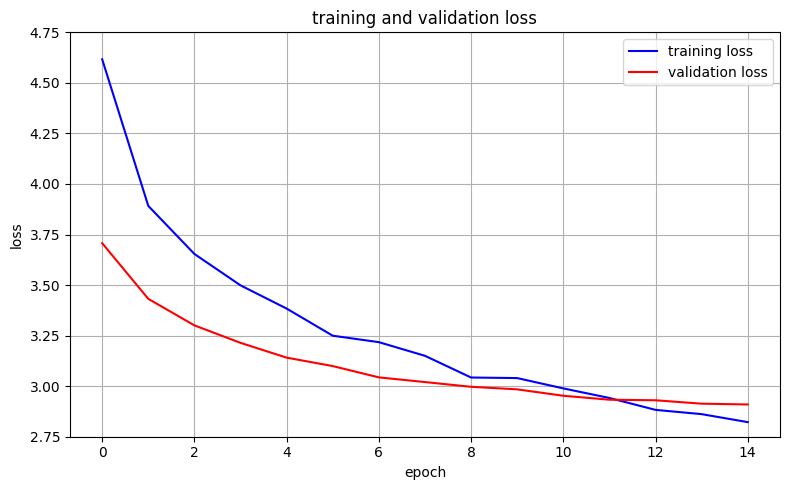


Improved training completed successfully!


In [45]:
# Initializing the ResumeableTrainer with all the new components.
improved_trainer = ResumeableTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    checkpoint_dir='improved_checkpoints'
)

print("ResumeableTrainer initialized and ready for the improved training run.")

try:
    print("\nSTARTING IMPROVED TRAINING RUN")

    improved_trainer.run_complete_training(
        train_loader,
        val_loader,
        TRAINING_CONFIG['num_epochs']
    )
    print("\nImproved training completed successfully!")

except Exception as e:
    print(f"\nTraining interrupted: {e}")
    print("Checkpoints have been saved. You can re-run this cell to resume.")
    import traceback
    traceback.print_exc()